In [1]:
MAX_TIME = 1
INIT_SIZE = 5

In [2]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '11-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'11-torch_bartz09_1min_5init_2023-04-29_08-37-55'

# Chapter 11: Sequential Parameter Optimization
## Hyperparameter Tuning: pytorch with fashionMNIST Data 

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython                                0.0.46
spotRiver                                 0.0.92
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


In [5]:
import torch
from tabulate import tabulate
import copy
import warnings
import numbers
import json
import calendar
import math
import datetime as dt
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_hyperparameters_for_fun,
    get_default_values,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X)
from spotPython.hyperparameters.prepare import (
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
)

from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch
from spotPython.utils.convert import get_Xy_from_df
from spotPython.plot.validation import plot_cv_predictions, plot_roc, plot_confusion_matrix
from spotPython.torch.netfashionMNIST import Net_fashionMNIST

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from functools import partial
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms

warnings.filterwarnings("ignore")

In [6]:
print(torch.__version__)
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS device: ", mps_device)

2.0.0
MPS device:  mps


## 0. Initialization of the Empty `fun_control` Dictionary

In [7]:
fun_control = {}

## 1. Load fashionMNIST Data

In [8]:
def load_data(data_dir="./data"):
    # Download training data from open datasets.
    training_data = datasets.FashionMNIST(
        root=data_dir,
        train=True,
        download=True,
        transform=ToTensor(),
    )
    # Download test data from open datasets.
    test_data = datasets.FashionMNIST(
        root=data_dir,
        train=False,
        download=True,
        transform=ToTensor(),
    )
    return training_data, test_data

In [9]:
train, test = load_data()

In [10]:
train.data.shape, test.data.shape
train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [11]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": None})


## 2. Specification of the Preprocessing Model

In [12]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )
prep_model = None
fun_control.update({"prep_model": prep_model})

## 3. Select `algorithm` and `core_model_hyper_dict`

In [13]:
# core_model  = RidgeCV
core_model = Net_fashionMNIST
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

### Modify hyperparameter of type factor

In [14]:
# fun_control = modify_hyper_parameter_levels(fun_control, "leaf_model", ["LinearRegression"])
# fun_control["core_model_hyper_dict"]

### Modify hyperparameter of type numeric and integer (boolean)

In [15]:
# fun_control = modify_hyper_parameter_bounds(fun_control, "delta", bounds=[1e-10, 1e-6])
# fun_control = modify_hyper_parameter_bounds(fun_control, "min_samples_split", bounds=[3, 20])
#fun_control = modify_hyper_parameter_bounds(fun_control, "merit_preprune", bounds=[0, 0])
# fun_control["core_model_hyper_dict"]

## 5. Selection of the Objective (Loss) Function

There are two metrics:

    1. `metric` is used for the river based evaluation via `eval_oml_iter_progressive`.
    2. `metric_sklearn` is used for the sklearn based evaluation.

In [16]:
fun = HyperTorch(seed=123, log_level=50).fun_torch
weights = 1.0
horizon = 7*24
oml_grace_period = 2
step = 100
weight_coeff = 1.0

fun_control.update({
               "data_dir": None,
               "checkpoint_dir": None,
               "horizon": horizon,
               "oml_grace_period": oml_grace_period,
               "weights": weights,
               "step": step,
               "log_level": 50,
               "weight_coeff": weight_coeff,
               "metric": None,
               "metric_sklearn": None
               })

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.

In [17]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [18]:
print(gen_design_table(fun_control))

| name       | type   |   default |   lower |   upper |
|------------|--------|-----------|---------|---------|
| l1         | int    |     5     |  2      |     9   |
| l2         | int    |     5     |  2      |     9   |
| lr         | float  |     0.001 |  0.0001 |     0.1 |
| batch_size | int    |     4     |  1      |     4   |
| epochs     | int    |     3     |  1      |     4   |


### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [19]:
spot_torch = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_torch.run()

Using mps device
[1,  2000] loss: 2.325
[1,  4000] loss: 1.164
[2,  2000] loss: 2.330
[2,  4000] loss: 1.166
[3,  2000] loss: 2.331
[3,  4000] loss: 1.165
[4,  2000] loss: 2.328
[4,  4000] loss: 1.165
Accuracy of the network on the validation data: 0.10195833333333333
Using mps device
[1,  2000] loss: 2.363
[1,  4000] loss: 1.178
[1,  6000] loss: 0.790
[1,  8000] loss: 0.591
[1, 10000] loss: 0.472
[1, 12000] loss: 0.394
[1, 14000] loss: 0.338
[1, 16000] loss: 0.295
[1, 18000] loss: 0.263
[2,  2000] loss: 2.364
[2,  4000] loss: 1.182
[2,  6000] loss: 0.787
[2,  8000] loss: 0.592
[2, 10000] loss: 0.474
[2, 12000] loss: 0.394
[2, 14000] loss: 0.338
[2, 16000] loss: 0.296
[2, 18000] loss: 0.262
[3,  2000] loss: 2.367
[3,  4000] loss: 1.180
[3,  6000] loss: 0.789
[3,  8000] loss: 0.591
[3, 10000] loss: 0.473
[3, 12000] loss: 0.394
[3, 14000] loss: 0.337
[3, 16000] loss: 0.296
[3, 18000] loss: 0.262
[4,  2000] loss: 2.364
[4,  4000] loss: 1.183
[4,  6000] loss: 0.787
[4,  8000] loss: 0.591
[

### 4 Results

In [20]:
SAVE = True
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_torch, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_torch =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

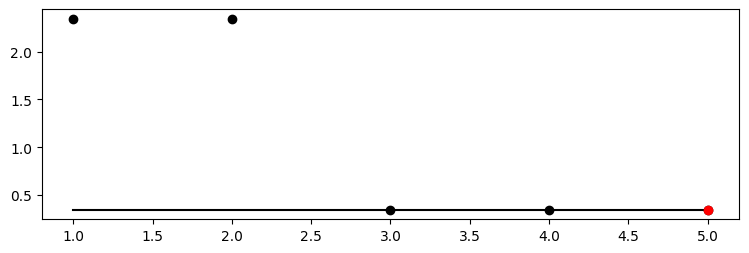

In [21]:
spot_torch.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")



* Print the Results

In [22]:
res = spot_torch.print_results(print_screen=False)
print(tabulate(
   res,
   headers=["Parameter", "Value"],
   numalign="right",
   tablefmt="github")
)

| Parameter   |      Value |
|-------------|------------|
| l1          |          8 |
| l2          |          7 |
| lr          | 0.00361165 |
| batch_size  |          3 |
| epochs      |          4 |


## Show variable importance

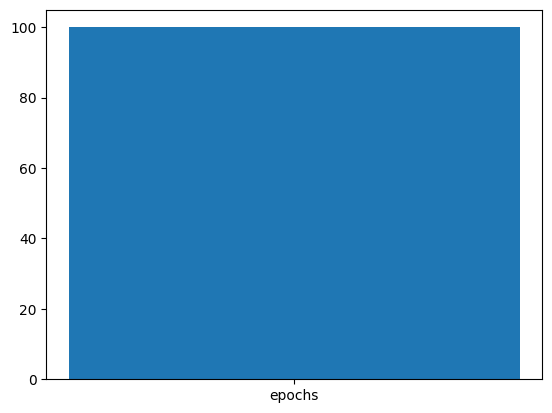

In [23]:
spot_torch.plot_importance(threshold=0.025, filename="../Figures.d/" + experiment_name+"_importance.pdf")

In [24]:
print(gen_design_table(fun_control=fun_control, spot=spot_torch))

| name       | type   |   default |   lower |   upper |                tuned |   importance | stars   |
|------------|--------|-----------|---------|---------|----------------------|--------------|---------|
| l1         | int    |       5.0 |     2.0 |     9.0 |                  8.0 |         0.00 |         |
| l2         | int    |       5.0 |     2.0 |     9.0 |                  7.0 |         0.00 |         |
| lr         | float  |     0.001 |  0.0001 |     0.1 | 0.003611652909973722 |         0.00 |         |
| batch_size | int    |       4.0 |     1.0 |     4.0 |                  3.0 |         0.00 |         |
| epochs     | int    |       3.0 |     1.0 |     4.0 |                  4.0 |       100.00 | ***     |


## Get Default Hyperparameters

In [40]:
values_default = get_default_hyperparameters_for_core_model(fun_control=fun_control,
                                                   hyper_dict=TorchHyperDict)
values_default

{'l1': 32, 'l2': 32, 'lr': 0.001, 'batch_size': 16, 'epochs': 8}

In [72]:
model_default = fun_control["core_model"](**values_default)
model_default


Net_fashionMNIST(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)

## Get SPOT Results

In [59]:
X = spot_torch.to_all_dim(spot_torch.min_X.reshape(1,-1))
print(X)


[[8.00000000e+00 7.00000000e+00 3.61165291e-03 3.00000000e+00
  4.00000000e+00]]


In [68]:
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_fashionMNIST(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

## Test Set Accuracy

In [75]:
model_default.test_accuracy(fun_control=fun_control)

Using mps device


0.1302

In [30]:
def test_accuracy(x, fun_control):
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    print(f"Using {device} device")
    x.to(device)

    # trainset, testset = load_data()
    testset = fun_control["test"]

    testloader = torch.utils.data.DataLoader(testset, batch_size=x.batch_size, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = x(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [70]:
model_spot.test_accuracy(fun_control=fun_control)

Using mps device


0.1018

In [32]:
min(spot_torch.y), max(spot_torch.y)

(0.34905356251782843, 2.342028640627861)

## Detailed Hyperparameter Plots

* For productive use, you might want to select:
  * `min_z=min(spot_torch.y)` and
  * `max_z = max(spot_torch.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

In [33]:
threshold = 0.025
impo = spot_torch.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_torch.y)
max_z = max(spot_torch.y)
n = spot_torch.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "../Figures.d/" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_torch.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

epochs:  100.0


## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [34]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_torch.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_torch.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)

## K-fold Cross-Validation

In [ ]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import KFold

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

class SimpleConvNet(nn.Module):
  '''
    Simple Convolutional Neural Network
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(1, 10, kernel_size=3),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(26 * 26 * 10, 50),
      nn.ReLU(),
      nn.Linear(50, 20),
      nn.ReLU(),
      nn.Linear(20, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  
  
if __name__ == '__main__':
  
  # Configuration options
  k_folds = 5
  num_epochs = 1
  loss_function = nn.CrossEntropyLoss()
  
  # For fold results
  results = {}
  
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Prepare MNIST dataset by concatenating Train/Test part; we split later.
  dataset_train_part = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor(), train=True)
  dataset_test_part = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor(), train=False)
  dataset = ConcatDataset([dataset_train_part, dataset_test_part])
  
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=k_folds, shuffle=True)
    
  # Start print
  print('--------------------------------')

  # K-fold Cross Validation model evaluation
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=10, sampler=test_subsampler)
    
    # Init the neural network
    network = SimpleConvNet()
    network.apply(reset_weights)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
    
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss value
      current_loss = 0.0

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        
        # Get inputs
        inputs, targets = data
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = network(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0
            
    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)

    # Evaluationfor this fold
    correct, total = 0, 0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data

        # Generate outputs
        outputs = network(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)
    
  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
  print('--------------------------------')
  sum = 0.0
  for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
  print(f'Average: {sum/len(results.items())} %')